目标检测中关于样本不均衡的处理办法
===

我们知道目标检测主要包括以Faster RCNN为代表的的两阶段方法，以及以SDD和YOLO为代表的的单阶段办法。虽然单阶段目标检测的速度很快，但是其精度往往比较低，究其原因，主要是样本极度不均衡造成的。

# 1.目标检测中的样本介绍

目标检测中，样本主要包括以下几类：

- 正样本：标签区域内的图像区域，即目标图像块
- 负样本：标签区域以外的图像区域，即图像背景区域
- 易分正样本：容易正确分类的正样本，在实际训练过程中，该类占总体样本的比重非常高，单个样本的损失函数较小，但是累计的损失函数会主导损失函数
- 易分负样本：容易正确分类的负样本，在实际训练过程中，该类占的比重非常高，单个样本的损失函数较小，但是累计的损失函数会主导损失函数
- 难分正样本：错分成负样本的正样本，这部分样本在训练过程中单个样本的损失函数教高，但是该类占总体样本的比例教小
- 难分负样本：错分成正样本的负样本，这部分样本在训练过程中单个样本的损失函数教高，但是该类占总体样本的比例教小

# 2.样本不均衡问题

所谓的样本不平衡问题是指在训练的时候各个类别的样本数量极不均衡。以基于深度学习的单阶段目标检测为例，样本类别不均衡主要体现在两方面：正负样本不均衡（正负样本比例达到1:1000）和难易样本不均衡（简单样本主导loss）．一般在目标检测任务框架中，保持正负样本的比例为1:3（经验值）。对于一个样本，如果它能很容易地被正确分类，那么这个样本对模型来说就是一个简单样本，模型很难从这个样本中得到更多的信息；而对于一个分错的样本，它对模型来说就是一个困难的样本，它更能指导模型优化的方向。对于单阶段分类器来说，简单样本的数量非常大，他们产生的累计贡献在模型更新中占主导作用，而这部分样本本身就能被模型很好地分类，所以这部分的参数更新并不会改善模型的判断能力，这会导致整个训练变得低效。

## 2.1.正样本(Postive Example)和负样本(Negative Example)的不平衡

Negative example的数量过多，导致Postive example的loss被覆盖，就算Postive example的loss非常大也会被数量庞大的negative example中和掉，这这些positive example往往是我们要检测的前景区域

## 2.2.难样本(Hard Example)和易样本(Easy Example)的不平衡

Hard example往往是前景和背景区域的过渡部分，因为这些样本很难区分，所以叫做Hard Example。剩下的那些Easy example往往很好计算，导致模型非常容易就收敛了。但是损失函数收敛了并不代表模型效果好，因为我们其实更需要把那些hard example训练好。

![Images](Images/03/02/03_04_001.jpg)

# 3.样本不均衡的处理办法

## 3.1.HNM(Hard Negative Mining-困难负样本挖掘)

难例挖掘的思想可以解决很多样本不均衡和简单样本过多的问题。将难例丢进数据集例，重新放入到网络中，就好像给网络准备一个错题集，哪里不会就重点做哪里。从名字上可以看出HNM只关注负样本，而OHEM则注意所有难例，不论正负。

### 3.1.1.为何要有难例挖掘这种东西？

我们知道，目标检测的输出个数是未知的，除了Ground truth训练时，模型永远无法百分百确信自己要在一张图上预测多少物体。所以目标检测问题的难点之一就是提高召回率。召回率是模型找到所有某类目标的能力(所有标注的真实边界框有多少被预测出来了)。检测时按照是否检出边界框与边界框是否存在，可以分为下表四种情况：

|    | 检测出边界框 | 未检测出边界框 |
| -- | ---------- | ----------- |
| 边界框存在 | TP-真阳性 | FN-假阴性 |
| 边界框不存在 | FP-误报 | TN-真阴性 |

$$Recall=\frac{TP}{TP + FN}$$

为了提高这个值，很直观的想法是“宁肯错杀一千，绝不放过一个”。因此在目标检测中，模型往往会提出远高于实际数量的区域提议（Region Proposal，SSD等one-stage的Anchor也可以看作一种区域提议）。但此时就会遇到一个问题，因为区域提议实在太多，导致在训练时绝大部分都是负样本，这导致了大量无意义负样本的梯度“淹没”了有意义的正样本。据统计，通常包含少量信息的Easy Example(通常是负样本),与包含有用信息的Hard Example(正样本+难负样本)之比是100000：100，这导致这些简单例的损失函数值将是难例损失函数的40倍！如下图所示
![Images](Images/03/02/03_04_002.jpg)

因此，为了让模型正常训练，我们必须要通过某种方法抑制大量的简单负例，挖掘所有难例的信息，这就是难例挖掘的初衷。难负例挖掘（Hard Negative Mining）就是在训练时，尽量多挖掘些难负例（hard negative)加入负样本集，这样会比easy negative组成的负样本集效果更好。

### 3.1.2.R-CNN中的Hard Negative Mining

RCNN中的难负例挖掘采用了自举法(bootstrap)的方法

- 先用初始的正负样本训练分类器（此时为了平衡数据，使用的负样本也只是所有负样本的子集），用训练好的分类器对样本进行分类,把其中错误分类的那些样本(hard negative)放入负样本子集，
- 再继续训练分类器
- 如此反复,直到达到停止条件(比如分类器性能不再提升).

也就是说，RCNN的Hard Negative Mining相当于给模型定制一个错题集，在每轮训练中不断“记错题”，并把错题集加入到下一轮训练中，直到网络效果不能上升为止。

1. 如果首次负例采样，直接获取IOU<0.3的region作为负例，用于后面训练SVM分类器
2. 如果不是首次负例采样，先用当前更新过的SVM分类器预测region，然后按照下面两个条件过滤负例
   - 负例，即最大IOU小于阈值
   - 分类错误，既然是负例，那么SVM计算值小于1

### 3.1.3.Fast RCNN中的Hard Negative Mining

IOU阈值+随机采样

### 3.1.4.SSD中的Hard Negative Mining

由于大多数边界框的IOU都比较低，会被认为是负样本，因此训练集可能会出现正负样本的不均衡。因此建议不要使用所有负样本，而是要保持正负样本1:3的比例。那么就需要过滤掉一些负样本，过滤的方法是抽样时按照置信度误差进行降序排列，选取误差较大的top-k作为训练的负样本，保证正负样本比例接近于1:3的比例。那么就需要过滤掉一些负样本，过滤的方法是抽样时按照置信度误差进行降序排列，选取误差较大的top-k作为训练的负样本，保证正负样本比例接近于1:3。

## 3.2.OHEM(Online Hard Example Mining-在线困难样本挖掘)

OHEM算法主要是针对训练过程中的困难样本自动选择，其核心思想是根据输入样本的损失进行筛选，筛选出困难样本(即对分类和检测影响较大的样本),然后将筛选得到的这些样本应用在随机梯度下降中训练。该算法主要应用于Fast RCNN中。

我们知道Fast RCNN主要包括两个部分

1. 卷积网络：主要有多个卷积层和max pooling层组成
2. ROI Pooling网络：主要包括ROI Pooling层，一些全连接层和两个损失层

在之前的HNM中，都必须先结束一轮训练，有点事后诸葛亮的感觉。用子网络对RoI Proposal预测的分数，来决定每个batch选用的样本，这样，输入子网络的RoI Proposal总为表现不好的样本，提高了监督学习的效率。具体来说，在实际操作中是将原来的一个ROI Network扩充为两个ROI Network，这两个ROI Network共享参数。其中前面一个ROI Network只有前向操作，主要用于计算损失；后面一个ROI Network包括前向和后向操作，以hard example作为输入，计算损失并回传梯度

![Images](Images/03/02/03_04_003.jpg)

具体来说，上面一个ROI Network是自读的，为所有的ROI在前向传递的时候分配空间。下面的ROI Network则同时为前向和后向分配空间。

- ROI经过ROI Pooling Layer之后生成Feature Maps，然后进入只读ROI Network得到所有ROI的Loss
- Hard ROI Sampler结构根据损失排序选出Hard Example
- 将Hard Example放入下层的ROI Network

实际训练的时候，每个mini-batch包含$N$个图像，共$R$个ROI，也就是每张图像包含$\frac{R}{N}$个ROI。经过hard ROI sampler筛选后得到$B$个hard example。作者在文中采用$N=2,R=4000,B=128$。
另外关于正负样本的选择：当一个ROI和一个ground truth的IOU大于0.5，则为正样本；当一个ROI和所有ground truth的IOU的最大值小于0.5时为负样本。

- 优点:对于数据的类别不平衡问题不需要采用设置正负样本比例的方式来解决，这种在线选择方式针对性更强；
- 优点:随着数据集的增大，算法的提升更加明显；
- 缺点:只保留loss较高的样本，完全忽略简单的样本，这本质上是改变了训练时的输入分布（仅包含困难样本），这会导致模型在学习的时候失去对简单样本的判别能力．

## 3.3.S-OHEM(基于Loss分布采样的在线困难样本挖掘)

## 3.4.A-Fast-RCNN(基于对抗生成网络的方式来生成困难样本)

## 3.5.Focal Loss(损失函数的权重调整)

## 3.6.GHM(损失函数梯度均衡化机制)

Faster R-CNN之所以能解决两个不平衡问题是因为其采用了下面两个策略：

1. 根据IoU采样候选区域，并将正负样本的比例设置成1:1。这样就解决了正负样本不平衡的问题；
2. 根据score过滤掉easy example，避免了训练loss被easy example所支配的问题。

# 2.Focal Loss

大神采用的解决方案是基于交叉熵提出了一个新的损失函数Focal Loss(FL)

$$FL(p_t)=-\alpha_t(1-p_t)^\gamma log(p_t)$$

FL是一个尺度动态可调的交叉熵损失函数，在FL中有两个参数$\alpha_t$和$\gamma$，其中$\alpha_t$的主要作用是解决正负样本的不平衡问题，$\gamma$主要是解决难易样本不平衡的问题。Focal Loss是交叉熵损失的改进版本，一个二分类交叉熵可以表示为：

$$CE(p,y)=\begin{cases}
-log(p) & y=1 \\
-log(1-p) & otherwise
\end{cases}$$

上面公式可以简写成

$$CE(p,y)=CE(p_t)=-log(p_t)$$

其中

$$p_t=\begin{cases}
p & y=1 \\
1-p & otherwise
\end{cases}$$

## 2.1.$\alpha$解决正负样本不平衡

平衡交叉熵的提出是为了解决正负样本不平衡的问题。它的原理很简单，为正负样本分配不同的权重比值$\alpha \in [0,1]$，取值如下

$$\alpha_t=\begin{cases}
\alpha & y=1 \\
1-\alpha & otherwise
\end{cases}$$

那么这个$\alpha$平衡交叉熵损失可以表示为$CE(p_t)=-\alpha_t log(p_t)$

$\alpha$的值往往需要根据验证集进行调整，论文中给出的是$0.25$

## 2.2.$\gamma$解决难易样本的不平衡

FL中$\gamma$的引入是为了解决难易样本不平衡的问题的

Text(0, 0.5, 'loss')

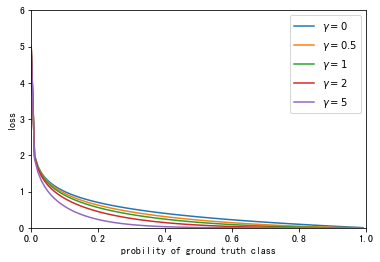

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import math

r = 0
x = np.linspace(0.00001, 1, num=100,endpoint=False)

# plt.figure(figsize=(10,8), facecolor='white')
plt.plot(x, -(1-x) ** 0 * np.log10(x), label="$\gamma=0$")
plt.plot(x, -(1-x) ** 0.5 * np.log10(x), label="$\gamma=0.5$")
plt.plot(x, -(1-x) ** 1 * np.log10(x), label="$\gamma=1$")
plt.plot(x, -(1-x) ** 2 * np.log10(x), label="$\gamma=2$")
plt.plot(x, -(1-x) ** 5 * np.log10(x), label="$\gamma=5$")
plt.legend(loc="upper right")
plt.xlim((0, 1))
plt.ylim((0, 6))
plt.xlabel('probility of ground truth class')
plt.ylabel('loss')
# plt.show()

上图中我们可以看出对于一些Well-classified examples(Easy Examples)虽然他们单个example的loss可以收敛到很小，但是由于它们的数量过于庞大，把一些hard example的loss覆盖掉。导致求和之后他们依然会支配整个批次样本的收敛方向。

一个非常简单的策略是继续缩小easy examples的训练比重，即给每个乘以$(1-p_t)^\gamma$。因为Easy Example的score $p_t$往往接近于1，那么$(1-p_t)^\gamma$值会比较小，因此example得到了抑制，相对于hard example得到了放大，如上图的$\gamma > 0$的那四条曲线。

FL的求导结果如下:
$$\frac{dFL}{dx}=y(1-p_t)^\gamma(\gamma p_t log(p_t)+p_t-1)$$

$\gamma$的值也可以根据验证集来调整，论文中给出的值是2

## 2.3.FL的最终形式

结合$\alpha$和$\gamma$就有了最终FL的形式。

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
def one_hot(index, classes):
    size = index.size() + (classes,)
    view = index.size() + (1,)
    mask = torch.Tensor(*size).fill_(0)
    index = index.view(*view)
    ones = 1.
    if isinstance(index, Variable):
        ones = Variable(torch.Tensor(index.size()).fill_(1))
        mask = Variable(mask, volatile=index.volatile)
    return mask.scatter_(1, index, ones)
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
    def forward(self, input, target):
        y = one_hot(target, input.size(-1))
        logit = F.softmax(input)
        logit = logit.clamp(self.eps, 1. - self.eps)
        loss = -1 * y * torch.log(logit) # cross entropy
        loss = loss * (1 - logit) ** self.gamma # focal loss
        return loss.sum()